# Imports and utility functions

In [3]:
import numpy as np
import time, glob, gc, os, sys
import pandas as pd
import seaborn as sns
import tifffile
import matplotlib.pyplot as plt
import xarray as xr
# sys.path.append("/data/srlab1/lakshay-yakir") #why not put this in your .bashrc file?
import tpae.data.ingest as ti

data_dir = '../uc-data'
raw_dir = f'{data_dir}/raw'
out_dir = f'{data_dir}/10u'
os.makedirs(f'{raw_dir}', exist_ok=True)
os.makedirs(f'{out_dir}', exist_ok=True)

pixelsize = 0.75488 # in microns
downsample_factor = int(10//pixelsize)

k = 10
repname = f'pca_k={k}_harmony'

# read in channel names and files 
channel_names_filepath = f'{data_dir}/channelNames.txt'
with open(channel_names_filepath, 'r') as file: 
    markers = file.read().splitlines()

files = glob.glob(f"{data_dir}/raw/run[1-46-8]/*.tif")
sample_ids = [f'{os.path.basename(os.path.dirname(file))}_{os.path.basename(file)}' for file in files]

# Read raw data and downsample

In [5]:
# convert all files to xarray

for file in files: 
    da = tifffile.TiffFile(file)
    da = da.asarray().astype('uint16')
    da = np.reshape(da, newshape = (-1, da.shape[2], da.shape[3])).transpose(1, 2, 0)
    da = ti.downsample(da, factor = downsample_factor)
    pixels_array_df = xr.DataArray(da, 
                               dims = ("y", "x", "markers"), 
                               coords = {"y": np.arange(da.shape[0], dtype = np.float32),
                                         "x": np.arange(da.shape[1], dtype = np.float32),
                                         'markers': markers}) #name=***, also that should equal the filename when you save
    run = os.path.basename(os.path.dirname(file))
    filename = os.path.basename(file)
    pixels_array_df.to_netcdf(f"/data/srlab1/lakshay-yakir/uc/uc-data/10u_temp/{run}/{filename}.cdf", #cdf vs nc?
                              format = "NETCDF4", 
                              encoding = {"__xarray_dataarray_variable__": {'zlib': True, 'complevel': 2}})
    # why not this?
    # da.to_netcdf(f'{outdir}/{sid}.nc', encoding={da.name: compression}, engine="netcdf4")
    

(349, 362, 80)
(349, 362, 80)
(349, 362, 80)
(349, 362, 80)
(349, 362, 80)


KeyboardInterrupt: 

**note:** 349 x 362 is smaller than other datasets we've looked at, just fyi. No action item

# Visual sanity checks

In [ ]:
# read in data
samples = [
    xr.open_dataset(f, engine='netcdf4')
    for f in glob.glob(f"{out_dir}/*.nc")
]

In [ ]:
vimentin = xr.concat([
    s.sel(marker='vimentin')
    for s in samples
])
# for s in samples:    
#     vimentin_array = np.zeros(shape=(349, 362, len(sample_ids)))
#     sample_vimentin = sample_da.sel(marker='vimentin').data
#     vimentin_array[:, :, i] = sample_vimentin
    
# vimentin_da = xr.DataArray(vimentin_array, 
#                            dims = ("y", "x", "samples"), 
#                            coords = {"y": np.arange(vimentin_array.shape[0], dtype = np.float32),
#                                      "x": np.arange(vimentin_array.shape[1], dtype = np.float32),
#                                      'samples': [f"vimentin_{sample_id}" for sample_id in sample_ids]})

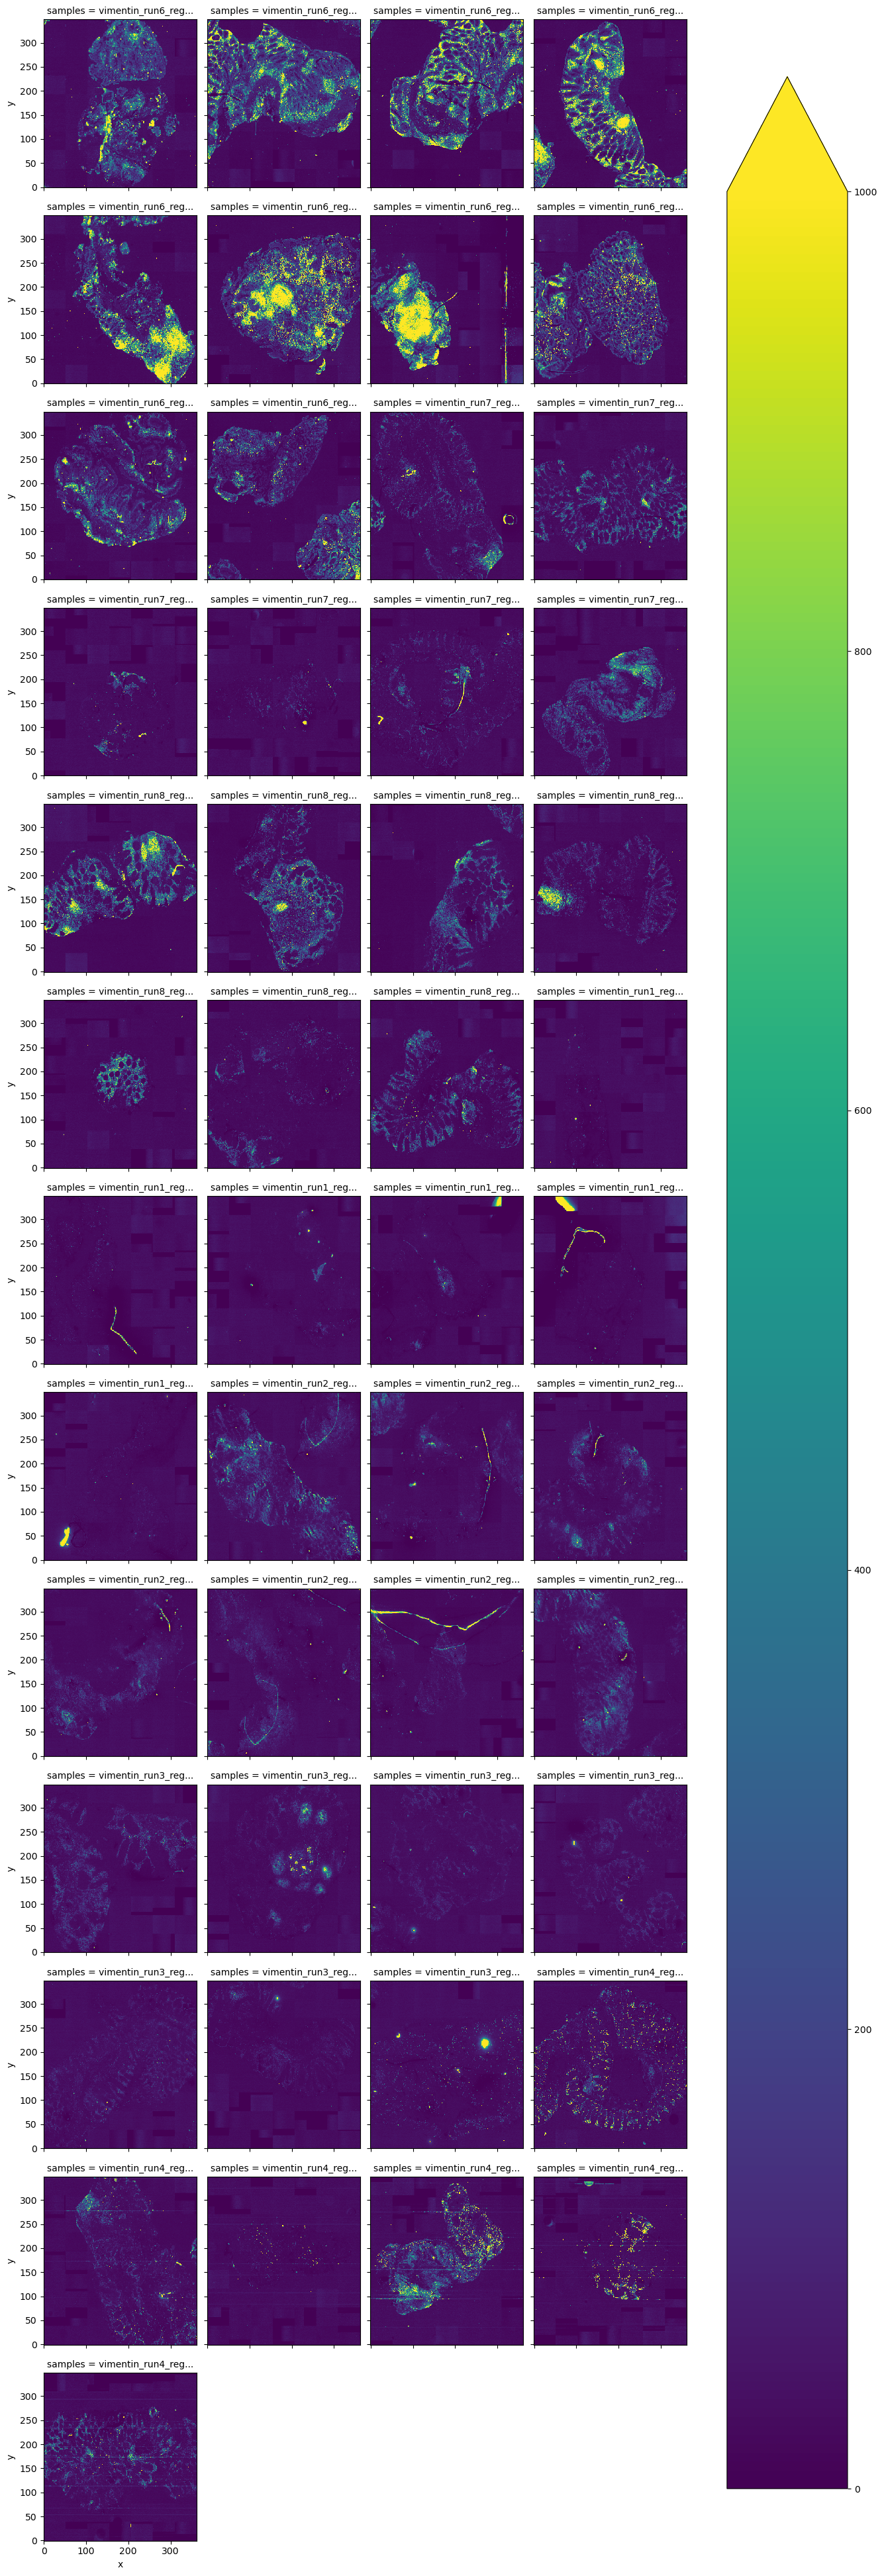

In [16]:
vimentin.plot(col='samples', col_wrap = 4, vmax = 1000)

# to-do

For prior code:
1) make sure all the random "code" I wrote actually runs
1) read in sample metadata file so you can assign sid's based on last column there
1) modify downsampling code to add 'sid' and 'donor' to s.attrs as well sid to s.name, and saves to f'{data_dir}/10u/counts' (with compression={'zlib': True, 'complevel': 2} and filename of {sid}.nc)
1) modify downsampling code so all files are saved in one flat directory
1) convince yourself 100% that marker names are in the correct order relative to the xarrays. (look at blanks, google image "vimentin pathology slide", look at the nuclear stains)

For future:
1) adapt code in scratch to determine tissue mask and produce an image with total intensity in red and foreground mask overlaid in white (with alpha=0.5) for all samples. can steal plotting code from ti.write_masks.
2) think about how to make foreground mask as well as possible

# Identify foreground

# scratch

In [ ]:
# could modify this code if you want
real_markers = markers[:-1]
neg_ctrls = markers[-1:]
blur_width = 5
from importlib import reload; reload(ti)

get_foreground = lambda s: ti.foreground_mask_ihc(s, real_markers, neg_ctrls, blur_width=blur_width)
ti.write_masks(downsampledpixelsdir, masksdir, get_foreground, sids)
os.system('say done')

In [29]:
# or could play around more with this code if needing control over more details
import cv2 as cv2 

run = os.path.basename(os.path.dirname(files[0]))
filename = os.path.basename(files[0])
sample = xr.open_dataset(f"/data/srlab1/lakshay-yakir/uc/uc-data/10u_temp/{run}/{filename}.cdf", engine='netcdf4') #use out_dir or wahtever as appropriate
raw_sample = sample.data
totals = raw_sample.sum(axis=2) - raw_sample[:,:,-1] # (subtracting off AF channel - will need to adapt to locations of blanks
totals -= totals.min()
totals /= (totals.max()/255)
totals = totals.astype('uint8')
blurred = cv2.GaussianBlur(totals,(5, 5),0)
_, mask = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
mask = mask.astype('bool')
print('npixels:', mask.sum())

array([[<Axes: title={'center': 'pixel_intensity'}>]], dtype=object)

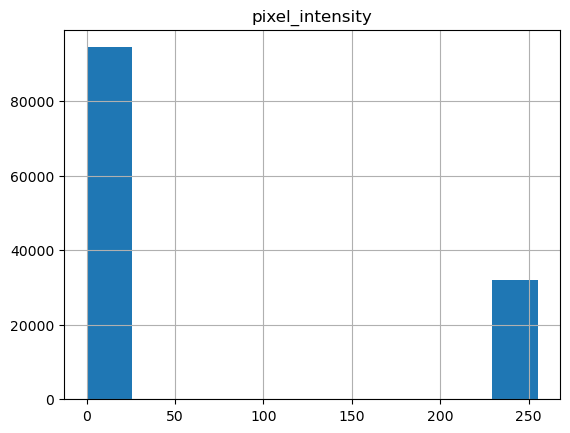

In [43]:
flattened_mask = np.ravel(mask)
fg_vs_bg_df = pd.DataFrame({"pixel_intensity": flattened_mask, 
                           "fg_or_bg": 0})
fg_vs_bg_df.loc[fg_vs_bg_df.pixel_intensity > 0, 'fg_or_bg'] = 1
fg_vs_bg_df.hist(column='pixel_intensity')

In [ ]:
for f in glob.glob('../BHAM-data/_qptiff/*.qptiff'):
    print('reading', f)
    sample = np.ascontiguousarray(tifffile.TiffFile(f).series[0].asarray().transpose(1,2,0))
    sid = f.split('/')[-1].split('.qptiff')[0]
    print('sid:', sid)
    print('sample shape:', sample.shape)
    
    print('downsampling')
    sample = downsample(sample, downsample_factor)
    np.save(f'{pixelsoutdir}/{sid}.npy', sample)
    print('sample shape:', sample.shape)
    
    gc.collect()
    print()

In [ ]:
# foreground selection code
import cv2 as cv2

sample = np.load(f)
print('sample shape:', sample.shape)

# determine which pixels are non-empty
totals = sample[:,:,:-1].sum(axis=2) - sample[:,:,-1] # (subtracting off AF channel)
totals -= totals.min()
totals /= (totals.max()/255)
totals = totals.astype('uint8')
blurred = cv2.GaussianBlur(totals,(blur_width, blur_width),0)
_, mask = cv2.threshold(blurred,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
mask = mask.astype('bool')
print('npixels:', mask.sum())